<a href="https://colab.research.google.com/github/VadimDu/Deep-Learning-to-predict-resistance-to-Fluoroquinolone-antibiotics/blob/main/Deep_Learning_to_predict_resistance_to_FQ_antibiotics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep learning to predict antibiotic resistance**
In this tutorial we will preform machine-learning (deep learning) analysis of bacterial DNA gyrase/topoisomerase in order to predict resistance to Fluoroquinolone antibiotics. We will use Convolutional Neural Network (CNN) based classifier to achieve it.

### **Fluoroquinolones resistance in bacteria**
The fluoroquinolones are potent, broad-spectrum antibiotics that have been used in medical practice for the treatment of severe or resistant infections. Fluoroquinolones (FQ) are potent inhibitors of bacterial type II topoisomerases, which are essential enzymes involved in key cellular processes including DNA replication. DNA gyrase and topoisomerase are both heterotetrameric type II topoisomerase enzymes comprising two copies of each of either a GyrA and GyrB subunit or a ParC and ParE subunit, respectively. FQ target DNA gyrase and topoisomerase with varying efficiency in different bacteria, inhibit their control of supercoiling within the cell, resulting in impaired DNA replication and cell death. FQ have been extensively used in human
and veterinary medicine due to their effectiveness against both Gram-positive and Gram-negative bacteria, and resistance to FQ is evidently common and can occur via a range of mechanisms. The most common mechanism of high-level FQ resistance is due to point mutation in one or more of the target genes (*gyrA* *gyrB*, *parC*,and *parE*). The region where mutations arise in these
genes is a short DNA sequence known as the quinolone resistance-deter-
mining region (QRDR). Mutations in the QRDR of these genes, resulting in amino acid substitutions, alter the target protein structure and subsequently the FQ-binding affinity of the enzyme, leading to drug resistance. For an extensive review of the topic, refer to (Redgrave et al. 2014): [link text](https://www.cell.com/trends/microbiology/fulltext/S0966-842X(14)00089-4?rss=yes%3Frss%3Dyes&mobileUi=0)

### **A short introduction to artificial neural networks**
An artificial neural network consists of layers of interconnected compute units (neurons). The depth of a neural network corresponds to the number of hidden layers, and the width to the maximum number of neurons in one of its layers. As it became possible to train networks with larger numbers of hidden layers, artificial neural networks were rebranded to “deep networks". In a typical configuration, the network receives data in an input layer, which are then transformed in a nonlinear way through multiple hidden layers, before final outputs are computed in the output layer. Neurons in a hidden or output layer are connected to all neurons of the previous layer. Each neuron computes a weighted sum of its inputs and applies a nonlinear activation function to calculate its output *f(x)*. The most popular activation function is the rectified linear unit (ReLU). The weights *w* between neurons are free parameters that capture the model’s representation of the data and are learned from input/output samples. Learning minimizes a loss function *L(w)* that measures the fit of the model output to the true label of a sample. During learning, the predicted label is compared with the true label to compute a loss for the current set of model weights. The loss is then backward propagated through the network to compute the gradients of the loss function and update weights. The loss function *L(w)* is typically optimized using gradient-based descent. In the figure below you can find a typical architecture of a neural network. <br/>
For a more detailed read about nerual networks and in general deep learning methods in computational biology, read this great paper (Angermueller et al. 2016): [link text](https://www.embopress.org/doi/full/10.15252/msb.20156651)

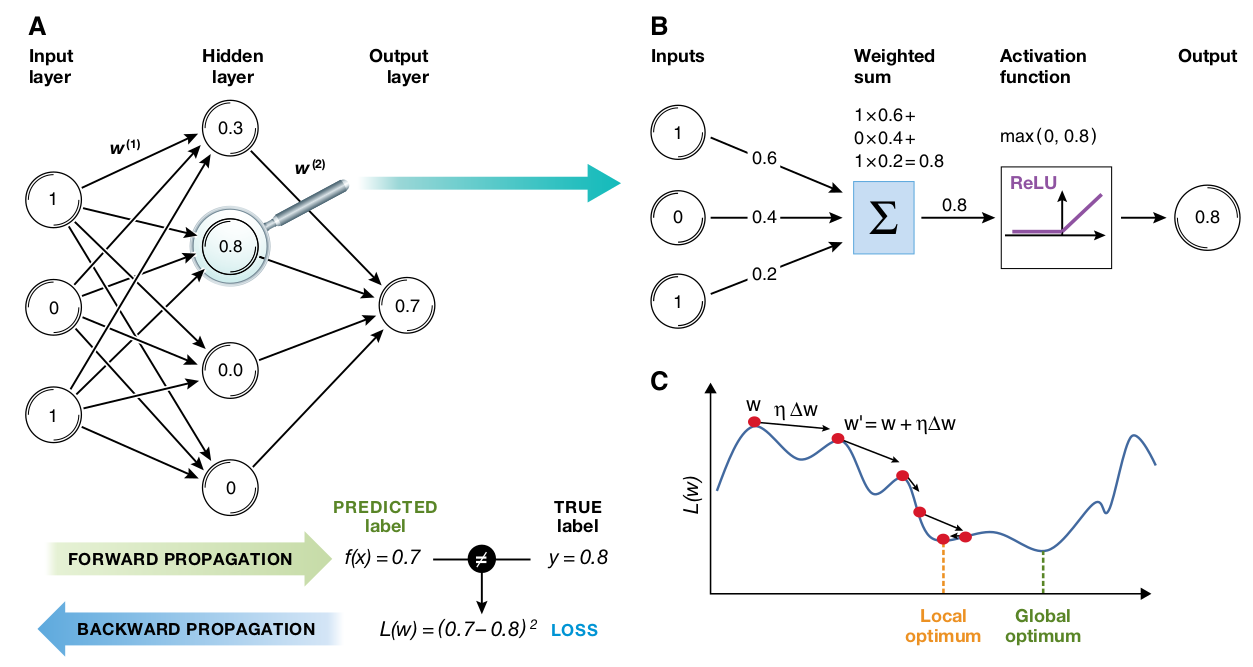

In [5]:
from IPython.display import Image
Image("/content/drive/My Drive/Input_data_for_CNN_deep-learning_FQ-resistance/Neural_net_intro1_Angermueller_et_al_2016.png")

### **A short introduction to Convolutional Neural Network**
CNNs are designed to model input data in the form of multidimensional arrays, such as two-dimensional images with three colour channels or one-dimensional genomic sequences with one channel per nucleotide. A convolutional layer consists of multiple maps of neurons, so-called feature maps or filters. Unlike in a fully connected network, each neuron within a feature map is only connected to a local patch of neurons in the previous layer, the so-called receptive field. In additiona, all neurons within a given feature map share the same parameters. Hence, all neurons within a feature map scan for the same feature in the previous layer, however at different locations. Different feature maps might, for example, detect edges of different orientation in an image, or different sequence motifs in a genomic sequence. The activity of a neuron is obtained by computing a discrete convolution of its receptive field, i.e. computing the weighted sum of input neurons, and applying an activation function. In the figure below, you can find the principles of using neural networks for predicting molecular traits from DNA sequence, adapted from Angermueller et al. 2016.<br/>For more details about CNNs, refer again to (Angermueller et al. 2016): [link text](https://www.embopress.org/doi/full/10.15252/msb.20156651)

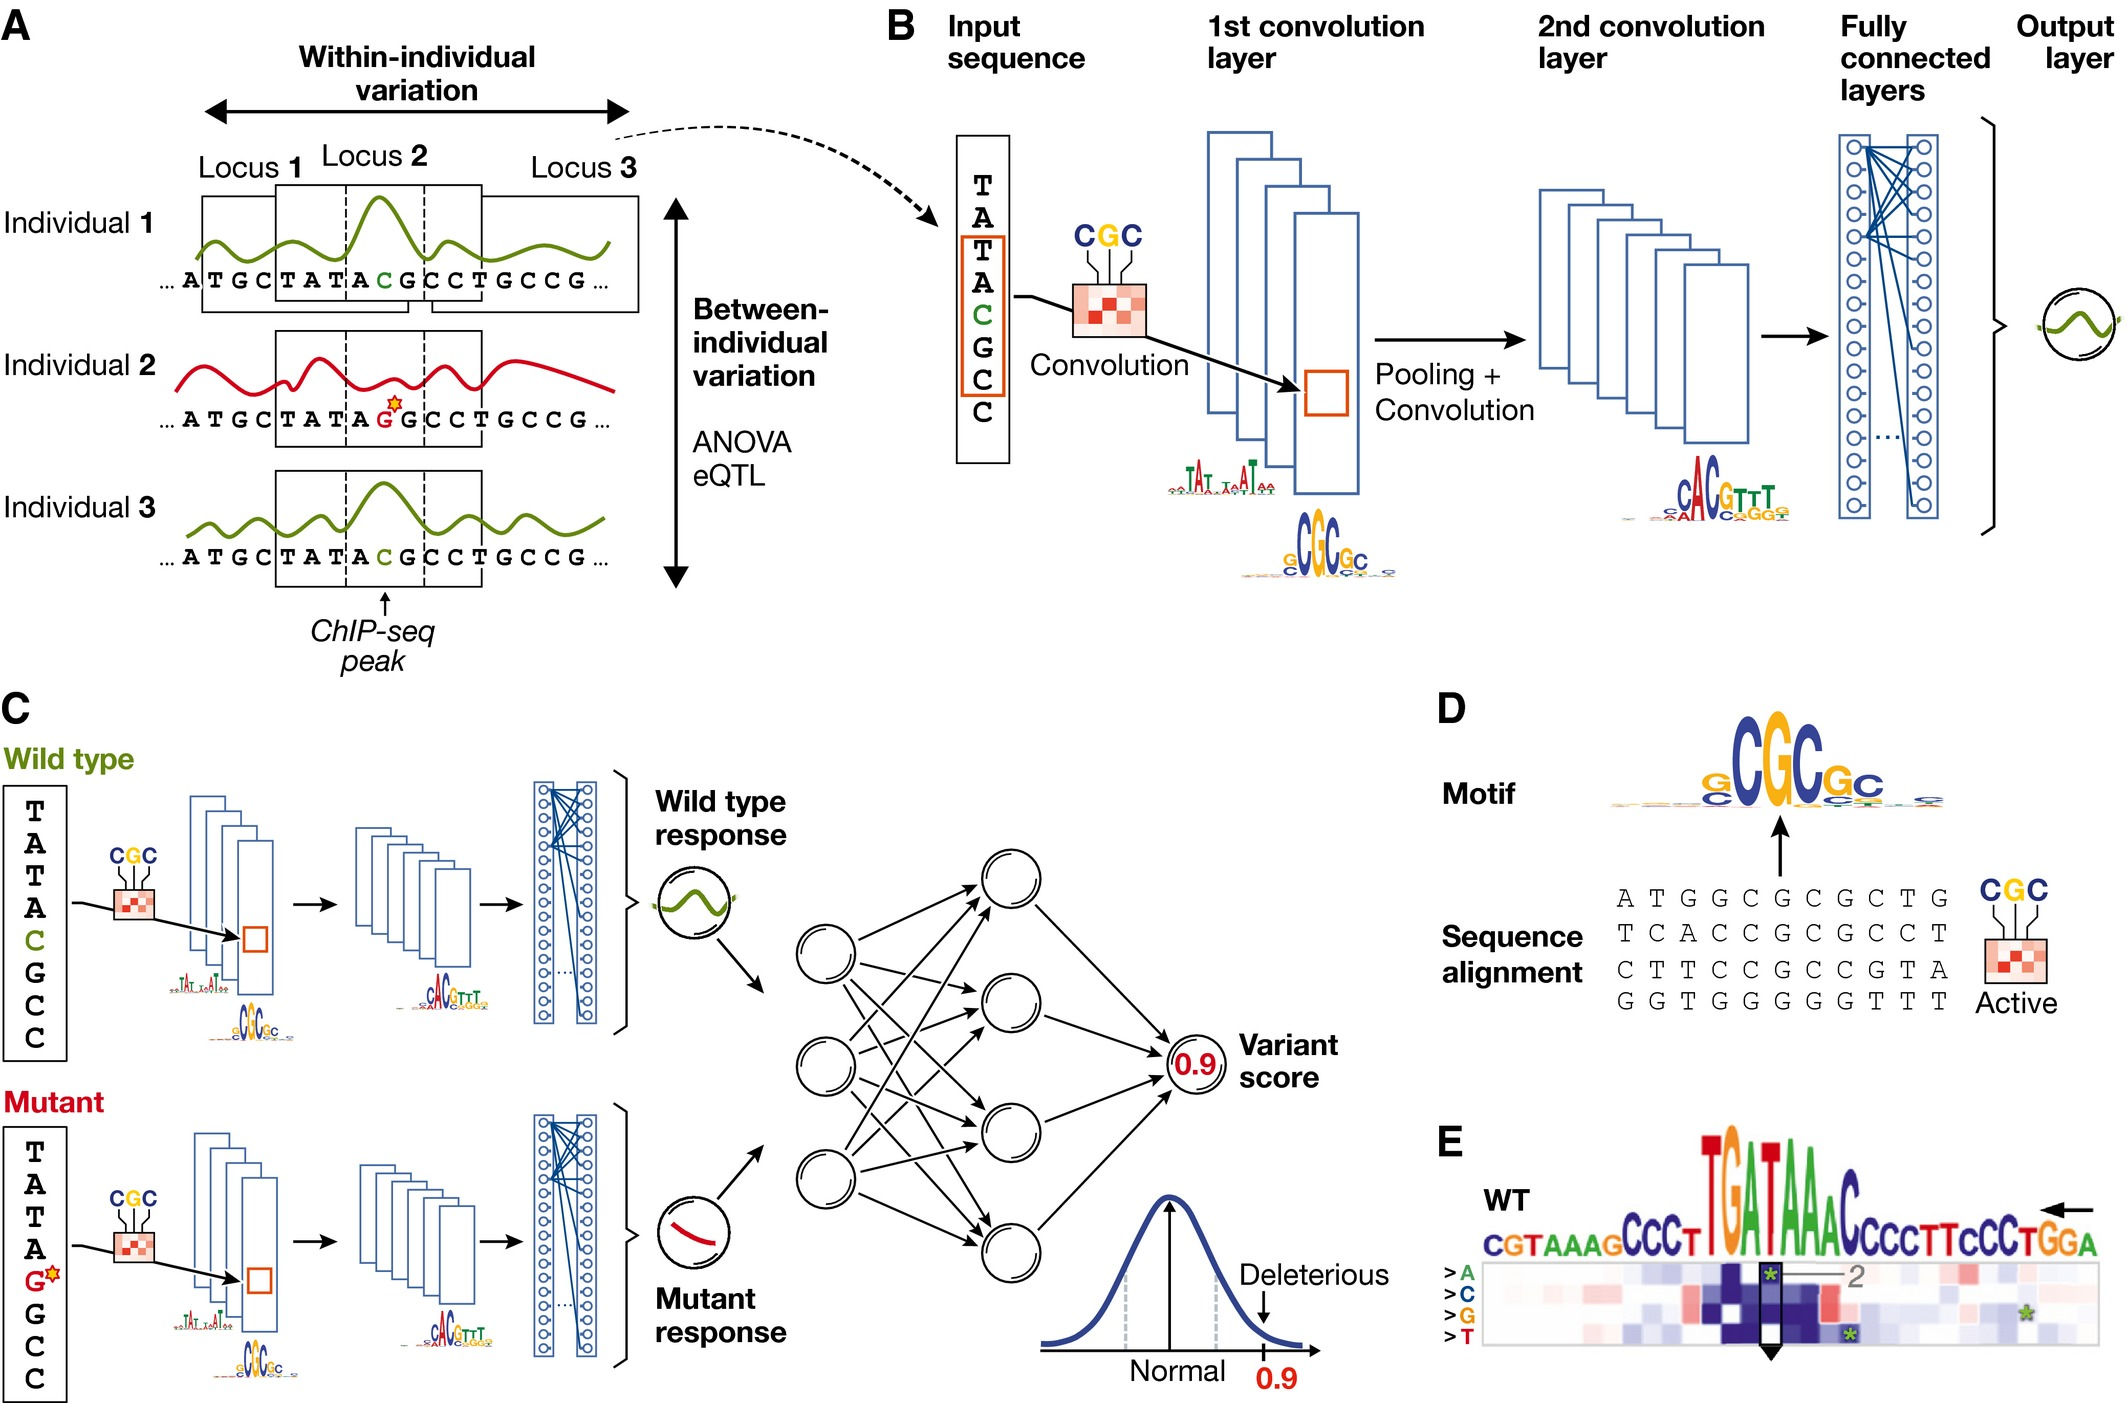

In [6]:
from IPython.display import Image
Image("/content/drive/My Drive/Input_data_for_CNN_deep-learning_FQ-resistance/Deep_learning_for_computational_biology_Fig2.jpg")

### **Module imports and data input**
Now let us start the real practical tutorial! First let's import all the necessary for the analysis modules and functions. The required modules are pandas, numpy, Bio, sklearn, tensorflow, matplotlib and seaborn.

In [ ]:
#Install missing Python3 modules in google-colab:
!pip3 install biopython
!pip3 install -U scikit-learn

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from Bio import SeqIO
import itertools
from sklearn.preprocessing import LabelEncoder #creating an integer encoding of labels
from sklearn.preprocessing import OneHotEncoder #creating a one hot encoding of integer encoded values
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2, l1 #weight regularization to prevent overfitting
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import load_model #Your saved model can be loaded later by calling the load_model() function

Now we will import our working files: the nucleotide sequences of the bacterial *gyrA* genes from each genome and a table with lables for each genome. The labels table consists of these columns: genome_id (need to match with sequence headers in the sequence file), genome_name (the exact bacterial strain), resistance_phenotype (clinically resistant or susceptible to antibiotics phenotype), and binary_label (1 for resistant, 0 for susceptible).

In [10]:
#Mount the Google Drive folders to be accessible with Google Colab:
from google.colab import drive
drive.mount('/content/drive')
%pwd
%ls /content/drive/My\ Drive/Input_data_for_CNN_deep-learning_FQ-resistance

!git clone https://github.com/VadimDu/Deep-Learning-to-predict-resistance-to-Fluoroquinolone-antibiotics.git

fatal: destination path 'Deep-Learning-to-predict-resistance-to-Fluoroquinolone-antibiotics' already exists and is not an empty directory.


In [9]:
fasta_path = "/content/drive/My Drive/Input_data_for_CNN_deep-learning_FQ-resistance/AMR_FQ_phenotypic_data_r-s_mod_genomes_ids_uniq_gyrA_gene_mod.fasta"
labels = pd.read_csv("/content/drive/My Drive/Input_data_for_CNN_deep-learning_FQ-resistance/AMR_FQ_phenotypic_data_r-s_mod_genomes_ids_uniq_gyr-par_nr_genomes_labels.txt", sep="\t", index_col=None, dtype={"genome_id" : str})
labels.shape

(10153, 4)

### **Data organization and filtering**
We will load the nucelotides sequences into Python with Bio module and parse them as regular fasta sequences. Then we will store them in a dictionary object (keys as the sequence headers, vals as the sequences themselfs). The reason we use dict here is that because dict keys must be unique, only non-duplicate headers (and thus sequences) are retained. This is useful if for some reason you have duplicate genes with a similar header (gene id), which you want to filter out to remove redundancy and data duplication. Finally, we will filter out genes longer than 2100bp and those that contain 'N's , and will trim the genes to use 2000bp (from 100 to 2100 bp position). Genes longer than 2100bp might be not 'real' *gyrA*, and in the first 100bp there is no useful information regarding FQ resistance. We also fix the sequence ids to match the ids in the labels table.

In [11]:
fasta_dict = {}
for sequence in SeqIO.parse(fasta_path, "fasta"):
    if (len(str(sequence.seq)) >= 2100 and 'n' not in str(sequence.seq)):
        fasta_dict[str(sequence.id).split("peg")[0].split(".")[0] + "." + str(sequence.id).split("peg")[0].split(".")[1]] = str(sequence.seq[100:2100])
len(fasta_dict)

10127

Now we will extract the seqeunce data from our dict into 2 lists, one for the header and the other for the sequence, for ease of downstream analysis. We will cut from the headers the "fig|" string and leave only the number to match the genome_id in the labels table. We also will subset the label table to include only those genes that passed filtration in the previous step.

In [12]:
#Convert to list, header & sequence separately:
header_nr = list(fasta_dict.keys())
fasta = list(fasta_dict.values())
#Make list of all the retained sequence headers, in order to update the labels list accordingly:
header_nr = [header_nr[i].split("|")[1] for i in range(len(header_nr))] #remove the "|" from the header
labels_subset = labels[labels["genome_id"].isin(header_nr)] #subset the labels list using "isin"
len(labels_subset )

10127

### **Data preparation for Convolutional Neural Network**
As we are using DNA sequence data represented as 4 nucleotide letters (A/a, G/g, C/c, T/t), we need to re-format the data into a format that can be passed to a deep learning algorithm such as CNN - real or integer values. In addition, our DNA sequences need to be organized in a matrix that would be fed to the CNN model. We will use one-hot encoding, which encodes every nucleotide in a sequence into a form of a 4-dimensional vector, 1-dim for each of the 4 nucelotides. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in the other dimensions. We then concatenate these 4-dim vectors together along the bases in the sequence to form a matrix. For each of the 10,127 sequences in our dataset, the matrix will be of 2000 x 4 size.<br/>
While we could use the labels as a vector of 1 or 0, it is often easier to similarly one-hot encode the labels, as we did the sequences.

In [13]:
#Encode the DNA nucleotide sequences using one-hot encoding:
one_hot_encoder = OneHotEncoder()   
input_fasta = []
for sequence in fasta:
    one_hot_encoded = one_hot_encoder.fit_transform(np.array(list(sequence)).reshape(-1,1))
    #Each sequence is represented by a matrix of 2000x4
    input_fasta.append(one_hot_encoded.toarray()) #Return a dense ndarray representation of this matrix.
input_fasta = np.stack(input_fasta) #Join (concatenate) a sequence of arrays along a new axis.
print(type(input_fasta))
print(input_fasta.shape) #Out: (N_samples, Seq_length, One-hot_encoded_cols=4)
print('DNA sequence #1 first 10-bases:\n',fasta[0][:10])
print('One-hot encoded DNA sequence #1 first 10-bases:\n',input_fasta[0][:10])

#One-hot encoding for the labels (resistant/susceptible)
one_hot_encoder = OneHotEncoder()
mlabels = np.array(labels_subset.iloc[:,3].values).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(mlabels).toarray()
print(input_labels.shape)

<class 'numpy.ndarray'>
(10127, 2000, 4)
DNA sequence #1 first 10-bases:
 tgccggatgt
One-hot encoded DNA sequence #1 first 10-bases:
 [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
(10127, 2)


The last thing left to do before building and running our model, is to randomly split our dataset into train set (75% of the samples) and test set (25%). We will train our model on the train set, and then test its performace on the previously unseen data from the test set. At a later step, we will further partition the training set into a training and validation set.

In [14]:
#Split the data into train and test set. At a later step, we will further partition the training set into a training and validation set.
x_train, x_test, y_train, y_test = train_test_split(input_fasta, input_labels, test_size=0.25, random_state=None)
x_train.shape
x_test.shape
y_train.shape
y_test.shape

(2532, 2)

### **Building the CNN model**
Now we will build our CNN model with these specific hyperparameters that were already tuned for this dataset. Hyperparameters tunining is beyond the scope of this tutorial, but basically, the choice of network architecture and its hyperparameters can be made in a data-driven and objective way by assessing the model performance on a validation data set. Here we use a 1D-CNN model, which is commonly used in deep learning for functional genomics applications. A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In our dataset, filters are sequence motifs within the DNA sequences. The 'filters' and 'units' arguments in the Conv1D (1D convolution layer neural net) and Dense (regular densely-connected neural net layer) are the number of neurons in each layer of our net. One way to improve the performance of a neural network is to add more layers. This might allow the model to extract and recombine higher order features embedded in the data. We will use cross entropy as the loss function, which is for binary classification problems and is defined in Keras as “binary_crossentropy“. We will define the loss function optimizer as the efficient stochastic gradient descent algorithm “adam“. This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problem.


In [15]:
#Build the CNN model
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, input_shape=(input_fasta.shape[1], 4), #input shape need to be the matrix of (N) sequence length x (M) one-hot encoded length
                 activation='relu', kernel_initializer = 'he_uniform', padding = 'same', kernel_regularizer=l1(0.001))) #the 1st hidden layer has 16 neurons
model.add(Conv1D(filters=16, kernel_size=3, input_shape=(input_fasta.shape[1], 4),
                 activation='relu', kernel_initializer = 'he_uniform', padding = 'same', kernel_regularizer=l1(0.001))) #the 2nd hidden layer has 16 neurons
#model.add(Dropout(0.5)) #Dropout is a regularization technique where randomly selected neurons are ignored (dropped-out) during training. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.
model.add(MaxPooling1D(pool_size=4)) #pooling layer summarizes adjacent neurons by computing, for example, the maximum or average over their activity, resulting in a smoother representation of feature activities
model.add(Flatten())
model.add(Dense(units=16, activation='relu', kernel_initializer = 'he_uniform', kernel_regularizer=l1(0.01))) #the 3rd hidden layer has 16 neurons
model.add(Dense(units=2, activation='softmax')) #the output layer has 2 neurons (our binary output - resistant or sensitive to antibiotics phenotype)
#the basic practical difference between 'sigmoid' and 'softmax' is that while both give output in [0,1] range, softmax ensures that the sum of outputs along channels (as per specified dimension) is 1 i.e., they are probabilities. Sigmoid just makes output between 0 to 1.

#Summarize the model in a table format
model.summary()

#Compile the model: selecting the loss function argument, optimization algorithm for the loss function, and perforance metrics. This is the last step before fitting & running the model
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['binary_accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2000, 16)          208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                128016    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 129,042
Trainable params: 129,042
Non-trainable params: 0
__________________________________________________

###**Fit & evaluate the model**
Now we are finally ready to run our model ("fit" it to the training dataset, i.e. train our model). We will further divide the training set into a training and validation sets, in order to train the model on the reduced training set, and test ("validate") it on the validation set.<br/>
Two additional parameters we need to set are 'epochs' and 'batch_size'. One epoch is one learning cycle where the model passes through the whole training data set. A batch size defines the number of samples to work through before updating the internal model parameters ("weights"). The number of epochs is usually large (10, 100, 1000 or more), allowing the learning algorithm to run until the error (the loss function) is sufficiently minimized.<br/>
We will visualize the loss and accuracy curves (also called learning curves) for the training (reduced) and validation sets . These plots can help to diagnose whether the model has over learned, under learned, or is suitably fit to the training dataset. Once the loss for the validation set stops improving or gets worse throughout the learning cycles (the "epochs"), it is time to stop training because the model has already converged and may be just overfitting.

In [16]:
history = model.fit(x_train, y_train, epochs=30, batch_size=32, verbose=1, validation_split=0.25)
#save model and its architecture to a file for later use to make predictions on other samples
model.save("/content/drive/My Drive/Input_data_for_CNN_deep-learning_FQ-resistance/CNN_model_n10127_all_gyrA_seq_2000nuc_l1_reg_v1.h5")
#load a previously trained model to use for prediction ("ready-to-use")
model_loaded = load_model("/content/drive/My Drive/Input_data_for_CNN_deep-learning_FQ-resistance/CNN_model_n10127_all_gyrA_seq_2000nuc_l1_reg_v1.h5", compile=True)

Epoch 1/30
178/178 [==============================] - 11s 61ms/step - loss: 2.4910 - binary_accuracy: 0.7563 - val_loss: 0.8739 - val_binary_accuracy: 0.7936
Epoch 2/30
178/178 [==============================] - 11s 59ms/step - loss: 0.8378 - binary_accuracy: 0.8181 - val_loss: 0.7706 - val_binary_accuracy: 0.8073
Epoch 3/30
178/178 [==============================] - 10s 59ms/step - loss: 0.7065 - binary_accuracy: 0.8524 - val_loss: 0.6305 - val_binary_accuracy: 0.8736
Epoch 4/30
178/178 [==============================] - 10s 59ms/step - loss: 0.6325 - binary_accuracy: 0.8706 - val_loss: 0.6072 - val_binary_accuracy: 0.8852
Epoch 5/30
178/178 [==============================] - 10s 58ms/step - loss: 0.5940 - binary_accuracy: 0.8750 - val_loss: 0.5751 - val_binary_accuracy: 0.8920
Epoch 6/30
178/178 [==============================] - 10s 58ms/step - loss: 0.5611 - binary_accuracy: 0.8836 - val_loss: 0.5352 - val_binary_accuracy: 0.8757
Epoch 7/30
178/178 [==============================] 

###**Make predictions with the model on unseen data ("test set") and plot performance metrics**
The last step in this tutorial (and in a standard machine-learning workflow) is to test our model on the test set which we put aside ("unseen" by the model dataset, 25% of our original input data). Then we will print a classification report consisting of commonly used performance metrics (precision, recall, accuracy), plot a confusion matrix (number of true positive, true negative, false positive and false negative predictions) and a ROC area under curve.<br/>
**Note:** before running the next piece of code, run first the accessory functions defined at the end of the tutorial

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1396
           1       0.87      0.93      0.90      1136

    accuracy                           0.91      2532
   macro avg       0.90      0.91      0.90      2532
weighted avg       0.91      0.91      0.91      2532

ROC AUC: 0.907
Confusion matrix:
 [[1237  159]
 [  81 1055]]


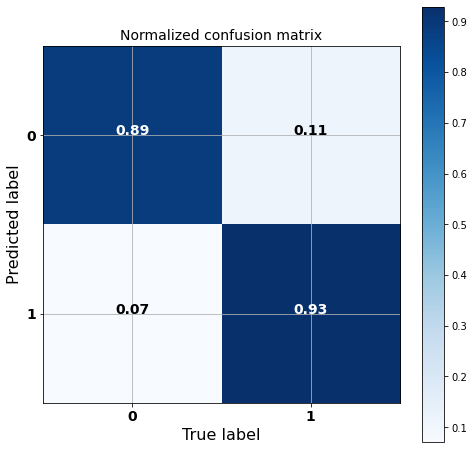

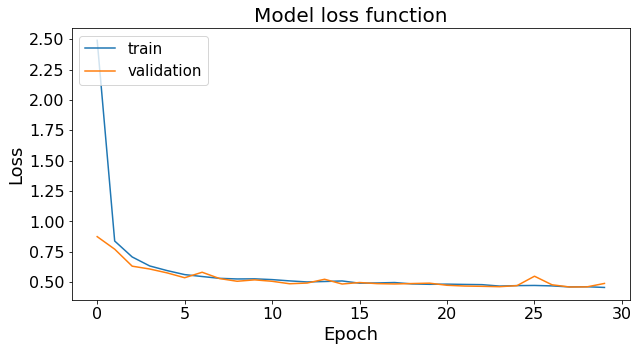

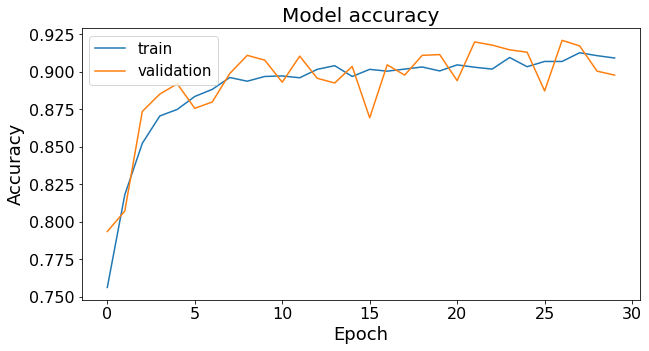

In [20]:
labels_pred = model.predict(x_test)
#Classification report (f1-score, presicion and recall):
print (classification_report (np.argmax(y_test, axis=1), np.argmax(labels_pred, axis=1)))
#ROC AUC (area under curve):
print ("ROC AUC: %.3f" % (roc_auc_score (np.argmax(y_test, axis=1), np.argmax(labels_pred, axis=1), average='weighted')))
#Generate confusion matrix:
confusion_mat (labels_pred, y_test)
#Generate learning curves:
plot_learning_curve (history, 'loss')
plot_learning_curve (history, 'accuracy')



### **Interpretation of CNN model results**
To help us interpretate the results of the CNN model, or why the model predicted a given outcome to a specific input, we can plot a saliency map. Saliency maps visualize the relative importance scores the model gives to each feature in the input data, in our case, to each nucleotide in the sequence, and how it affects the outcome label. Positive values in the map tell us that a small change to that nucleotide will change the output value, therefore which nucleotides are the most informative for classifying the bacterial *gyrA* into a resistant or sensitive allelles.<br/>
We can plot saliency map for one input sequence at a time, so let's choose one of interest (but any other sequence is good as well), with an index of 8720 which is a resistant *Klebsiella pneumoniae* (a bad bug, especially in hospitals setting...). For better visualization (and due to prior knowledge of where to look for...), we will plot only the first 500 bp out of 2000 bp (in essence it's 100-600bp).

      genome_id                     genome_name resistant_phenotype
8743  573.14442  Klebsiella pneumoniae KPN852ec           Resistant


Text(0.5, 1.0, 'Saliency map for bases in a gyrA sequence')

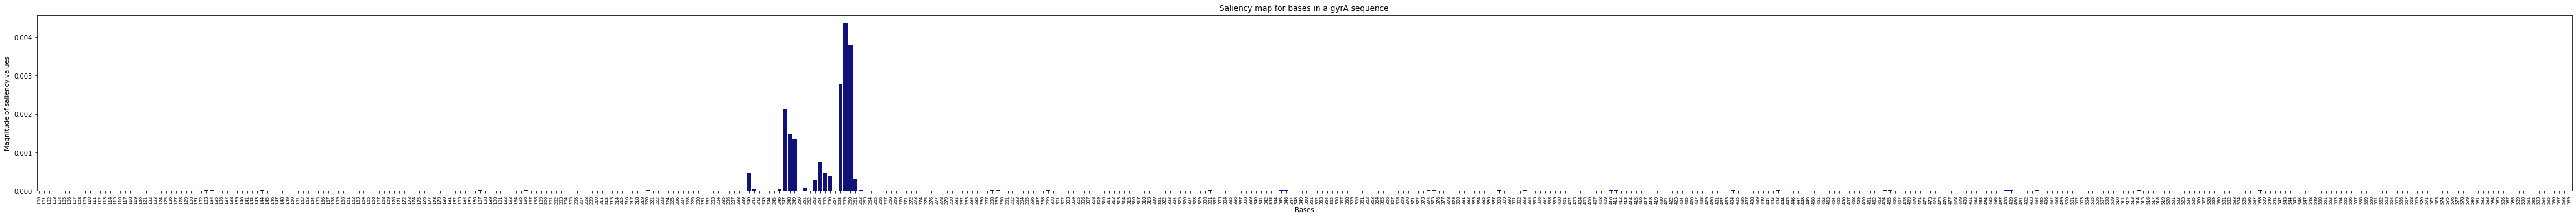

In [21]:
#Can we understand why the neural network classifies a training point in the way that it does? To do so, we can compute a saliency map, which is the gradient of the model's prediction with respect to each individual nucleotide

#Add a new running number to the labels_subet table to match sequence locations in input_fasta matrix
labels_subset = labels_subset.assign (sequence_index = np.arange(0,len(labels_subset),1))

#Select a specific sequence from the labels table for which to calculate the saliency map
seq_index = 8720
print(labels_subset[labels_subset.sequence_index == seq_index][["genome_id","genome_name","resistant_phenotype"]])

#Calculate the saliency map for a specific sequence, based on our CNN model:
sal = compute_salient_bases(model, input_fasta[seq_index])

#subset only part of the 2000-nucleotide sequence that we wish to plot saliency map (for ease of visualization)
sal_pt = sal[0:500]

#Plot the saliency map:
plt.figure(figsize=[70,5])
ax = sns.barplot(x=np.arange(len(sal_pt)), y=sal_pt, color='darkblue')
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(ticks=np.arange(len(sal_pt)), labels=np.arange(100, len(sal_pt)+100, 1), rotation=90, fontsize=7) #+100 to offset that the fasta is starts from the 100th nucleotide
plt.title('Saliency map for bases in a gyrA sequence')
#plt.savefig("/content/drive/My Drive/Input_data_for_CNN_deep-learning_FQ-resistance/CNN_saliency_map_gyrA_Klebsiella_8720index_RES_100-600.png", format='png', dpi=300, bbox_inches='tight')


We can nicely see a group of nucleotides in positions 246 to 256 with the highest score (and another relatively high score group at 274-277), which according to the model are more informative for the prediction. If you plot the whole 2000bp, you will find several other nucleotides with a non-zero score, but nothing as high as the group at 246-256 bp. This concludes that only several nucleotides have anything to do with FQ-antibiotic resistance.<br/>
This matches perfectly to well known positions in *gyrA* genes where mutations change the amino-acid sequence of the proten (QRDR - remember?), thus inhibit FQ antibiotics from binding and provides resistance to the bacteria. Mutations in position 83 over the amino-acid sequence, which corresponds to nucleotide 249 (codons 247-249) are the most common and also provides a high-level clinical resistance.

### **Conclusions**
Convolutional neural networks can effectively classify bactarial *gyrA* genes to whether these bacteria are resistant or sensitive to Fluoroquinolone antibiotics (for which *gyrA* is the primary target) based on clinically relevant phenotype. The model can be further improved with an extensive hyperparameters fine-tuning using grid-search or simply by tweaking some of the model's parameters (number of layers, number of neurons in each layer and regularization penalties).<br/>
In this tutorial we just confirmed already a well known mutation in the *gyrA* gene, but using machine-learning we can try to discover novel mutations in previously unknown positions or even in novel genes - which of course will require experimental validation in-vitro or/and in-vivo.

### **Acknowledgment**
This tutorial was partially adopted from Nikolay Oskolkov's tutorial on using deep learning for ancient human DNA analysis ([link text](https://github.com/NikolayOskolkov/DeepLearningAncientDNA)), from Angermueller et al. 2016 review paper on deep learning in computational biology, and from Machine Learning Mastery by Jason Brownlee.

In [19]:
#Accessory functions for plotting confusion matrix, learning curves and saliency maps

def confusion_mat(pred_labels, true_labels):
    '''Generate confusion matrix plot'''
    cm = confusion_matrix(np.argmax(true_labels, axis=1), 
                          np.argmax(pred_labels, axis=1))
    print('Confusion matrix:\n',cm)
    
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    
    plt.figure(figsize=[8,8])
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix', fontsize=14)
    plt.colorbar()
    plt.xlabel('True label', fontsize=16); plt.ylabel('Predicted label', fontsize=16)
    plt.xticks([0, 1], fontsize=14, fontweight='bold'); plt.yticks([0, 1], fontsize=14, fontweight='bold')
    plt.grid('off')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'), fontsize=14, fontweight='bold',
                 horizontalalignment='center',
                 color='white' if cm[i, j] > 0.5 else 'black')

def plot_learning_curve(model_history, param):
    '''Generate learning curve for log loss function and for accuracy.
    Accepts a mode history object (tensorflow.python.keras.callbacks.History) and a parameter to plot (accuracy or loss)'''
    opt = ('loss', 'accuracy')
    try:
        assert param in opt
    except AssertionError:
        print("Parameter %s is not valid, choose from ('loss', 'accuracy')" % param)
    else:
        if param == 'loss':
            plt.figure(figsize=(10,5))
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('Model loss function', fontsize=20)
            plt.ylabel('Loss', fontsize=18) #Loss
            plt.xlabel('Epoch', fontsize=18)
            plt.yticks(fontsize=16)
            plt.xticks(fontsize=16)
            plt.legend(['train', 'validation'], loc='upper left', fontsize=15)
        elif param == 'accuracy':
            plt.figure(figsize=(10,5))
            plt.plot(history.history['binary_accuracy'])
            plt.plot(history.history['val_binary_accuracy'])
            plt.title('Model accuracy', fontsize=20)
            plt.ylabel('Accuracy', fontsize=18)
            plt.xlabel('Epoch', fontsize=18)
            plt.yticks(fontsize=16)
            plt.xticks(fontsize=16)
            plt.legend(['train', 'validation'], loc='upper left', fontsize=15)

import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
    '''Compute saliency for a specific sequence based on the model'''
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
    compute_gradients = K.function(inputs = input_tensors, outputs = gradients)  
    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients([x_value])[0][0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal
